In [1]:
# Импортирование библиотек для иницализации основных параметров системы
from calc_tools import Fazy, System, Garmoniki, Rachety, Looper

# Импортирование неодходимых библиотек
from os import path
import time
import pandas as pd, numpy as np
from collections import namedtuple
from calc_tools import pairwise_1, pairwise_2
from scipy.linalg import logm, expm, sqrtm
from multiprocessing import Pool
from numpy.linalg import inv

# Импортирование библиотек для визуализации данных !!!!!
import matplotlib.pyplot as plot
import matplotlib as mpl
import seaborn as sns
import plotly as pt
import plotly.express as px
%matplotlib inline
import plotly.graph_objects as go

In [2]:
# Задание значении характеристик материала для фаз и троса
Faza_A = Fazy("Фаза А", 35.336, 1.0, 240.0, 0.0, 19.0)
Faza_B = Fazy("Фаза В", 35.336, 1.0, 240.0, 6.3, 19.0)
Faza_C = Fazy("Фаза С", 35.336, 1.0, 240.0, 4.2, 25.0)
Tross = Fazy("Тросс", 17.336, 8.0, 240.0, 2.1, 28.0)


# В данном случае у нас будет 50 гармоник от [1 до 50]
garmoniki = Garmoniki(50)


# Создание объекта для проведения расчетов
rashet = Rachety()


# Вычисление погонных активных сопротивлении для фаз и троса.
# Получаем матрицу с размерностью [4 на 50]
pogon_aktiv_soprotiv_faz = rashet.pogon_aktiv_soprotiv(Fazy, garmoniki)


# Вычисление погонных индуктивных сопротивлении для фаз и троса.
# Получаем матрицу с размерностью [4 х 4 х 50]
inductiv_soprotiv_faz = rashet.inductiv_soprotiv(Fazy, garmoniki)


# Вычисление погонных ёмкостных проводимостей для фаз и троса.
# Получаем матрицу с размерностью [4 х 4 х 50]
emkostn_provodimost_faz = rashet.emkostnaya_provodimost(Fazy, garmoniki)


# Матрица полных погонных прводимостей
Y = rashet.polnaya_provodimost(emkostn_provodimost_faz)


# Матрица полных погонных сопротивлении
Z = rashet.polnoe_soprotivlenye(inductiv_soprotiv_faz, pogon_aktiv_soprotiv_faz)


# Расчет комплексных квадратных матриц лямбда_напряж и лямбда_ток
# Произведение матриц собственных и взаимных погонных сопротивлений и проводимостей
Au = np.matmul(Z, Y)
Ai = np.matmul(Y, Z)


# Функция для расчета комплексных квадратных матриц лямбда_напряж и лямбда_ток
def calc_lambda(Mat):
    temp_array = list()
    for i in range(len(garmoniki)):
        lambda_i =  sqrtm(Mat[i])
        temp_array.append(lambda_i)
    lambda_U = np.array(temp_array)
    return lambda_U


# Вызов функции и произведение расчетов
lambda_U = calc_lambda(Au)
lambda_I = calc_lambda(Ai)


# Функция для расчета комплексных квадратных матриц экспонен_напряжения и экспонента_ток
def calc_exponents(lambd, dlina):
    temp_array1 = list()
    temp_array2 = list()

    for i in range(len(garmoniki)):
        expm_i = expm(np.dot(lambd[i], dlina))
        temp_array1.append(expm_i)

    for i in range(len(garmoniki)):
        expm_i = expm(np.dot(lambd[i], -1*dlina))
        temp_array2.append(expm_i)

    pos_exponent = np.array(temp_array1)
    neg_exponent = np.array(temp_array2)

    return pos_exponent, neg_exponent


# Длина линии выбрана как 7км (пример)
pos_U_exponent, neg_U_exponent = calc_exponents(lambda_U, 1)
pos_I_exponent, neg_I_exponent = calc_exponents(lambda_I, 1)



In [3]:
# Класс для рабочих методов для получения значении с файла 
class PhaseHolder():
    
    volt = None
    
    def __init__(self, to_put):
        self.df = None
        self.add_df = None
        self.to_put = to_put
        
        
    def __call__(self, iu):
        iu = iu.lower()
        if iu == 'u':
            return self.df.iloc[:int(len(self.df.index)/2),:]
        if iu == "i":
            return self.df.iloc[int(len(self.df.index)/2):,:].reset_index(drop=True)
    
    
     # Метод для получения значении отдельной гармоники [Начиная со  2-ой]
    def get_harmonic(self, harmonic, iu):
        check_dict = {"u":4,"i":5}
        har = harmonic; iu = iu.lower();
        phase_df = getattr(self, 'df')
        all_columns = len(phase_df.columns)
               
        if iu == 'u':
            phase_df = phase_df.iloc[:int(len(phase_df.index)/2),:]
        if iu == 'i':
            phase_df = phase_df.iloc[int(len(phase_df.index)/2):,:]
        for i, (a, p) in enumerate(pairwise_2(range(all_columns)), start=2): # Начало 2 !!!
            if i == har:
                A = phase_df.iloc[:,a].reset_index(drop=True) * self.add_df.iloc[:,check_dict[iu]].reset_index(drop=True)                
                P = phase_df.iloc[:,p].reset_index(drop=True); Pn = P.apply(lambda entry: np.sin(entry*np.pi/180))                

                SIN = A * Pn
        return SIN.reset_index(drop=True)
        
    
    
    # Метод для сложения всех гармоник для определенного присоединения я его фазы + значение
    # основного(номинального) напряжения
    def add_harmonics(self, iu):
        check_dict = {"u":4,"i":5}
        SIN = None; iu = iu.lower();
        phase_df = getattr(self, 'df')
        all_columns = len(phase_df.columns)
        if iu == 'u':
            phase_df = phase_df.iloc[:int(len(phase_df.index)/2),:]
        if iu == 'i':
            phase_df = phase_df.iloc[int(len(phase_df.index)/2):,:]
        for a, p in pairwise_2(range(all_columns)):
            A = phase_df.iloc[:,a].reset_index(drop=True) * self.add_df.iloc[:,check_dict[iu]].reset_index(drop=True)
            P = phase_df.iloc[:,p].reset_index(drop=True); Pn = P.apply(lambda entry: np.sin(entry*np.pi/180))
            
            if type(SIN)==type(None):
                SIN = A * Pn
            else:
                SIN += A * Pn
        return SIN.reset_index(drop=True)
        
        
    def get_rms(self, iu):
        iu = iu.lower();
        if iu == "u":
            return self.add_df.iloc[:,2].reset_index(drop=True)
        if iu == "i":
            return self.add_df.iloc[:,3].reset_index(drop=True)
    
    def get_main_harm(self, iu):
        iu = iu.lower();
        if iu == 'u':
            a = 4; p = 6;
        if iu == "i":
            a = 5; p = 7;
        A = self.add_df.iloc[:,a].reset_index(drop=True)
        P = self.add_df.iloc[:,p].reset_index(drop=True); Pn = P.apply(lambda entry: np.sin(entry*np.pi/180))    
        SIN = A * Pn
        return SIN
    

# Класс для инициализации основных атрибутов для присоединении
class AttribHolder():
    
    def __init__(self):
        self.naimen=None
        self.faza_A=PhaseHolder(None) 
        self.faza_B=PhaseHolder(None) 
        self.faza_C=PhaseHolder(None)
        
        
# Класс для чтения файла EXCEL и предобработки имеющихся там данных   
class PodStans():
    
    check = type(None)    
    """ 
    В объекте данного класса будут следующие атрибуты:
        - .vse_prisoed --> возвращает список всех присоединении для данной подстанции
        - .prisoed_n   --> n - номер присоединения. n-ое количество атрибутов для каждого 
                            присоединения. (Назначается автоматически по мере чтения Excel файла)  

                далее, вышеуказанный атрибут(-ы), в свою очередь, имеет(-ют) в себе атрибуты:
                    - .naimen   --> наименование присоединения 
                    - .faza_A   --> гармоники для фазы А
                    - .faza_B   --> гармоники для фазы В
                    - .faza_C   --> гармоники для фазы С
                
                             а каждый атрибут фазы имеет следующие методы:
                                - .get_harmonic(<harmonic>, <iu>)
                                        harmonic - Номер гармоники [2-50]
                                        iu - Ток или Напряжение ["U" или "I"]
                                - .add_harmonics(<iu>)
                                        iu - Ток или Напряжение ["U" или "I"]
                                - .get_rms(<iu>)
                                        iu - Ток или Напряжение ["U" или "I"]
                                - .get_main_harm(<iu>)
                                        iu - Ток или Напряжение ["U" или "I"]
                                
   """

    # Инициализация файла и рабочих атрибутов. Вызов создающих методов
    def __init__(self, path, *,volt=110, harm_num=49):
        self.file_path = path
        self.harm_num = harm_num
        self.excel_file = pd.ExcelFile(path)
        self.sheet_names = self.excel_file.sheet_names
        self.label_started = dict()
        self.get_prisoed_labels(self.excel_file, self.label_started)
        self.create_arrange_prisoed()
        PhaseHolder.volt = volt*10**3
        self.vse_prisoed = list(self.label_started.keys())
    
    
    # Метод для выведения количества и присоединении в файле
    def get_prisoed_labels(self, excel_file, label_started):
        
        dataframe = pd.read_excel(excel_file, excel_file.sheet_names[0], header=None)
        for i, row in enumerate(dataframe.iloc[:,0]):
            if type(row) == str:
                label_started[row] = i 
            else: 
                continue
        
        for i, item in enumerate(label_started.keys()):
            label_started[item] -= i
    
    
    # Метод для добавления таблицы гармоник
    def add_dataframes(self, dataframe, phase):
        
        for pris_num, chunk in enumerate(pairwise_1(list(self.label_started.values())+[None]), start=1):
            nach, kon = chunk
            cleaned_df = dataframe.dropna(thresh=50)

            faza_new = PhaseHolder(cleaned_df.iloc[nach:kon, :self.harm_num*2])
            
            pris = getattr(self, "prisoed_"+str(pris_num))
            faza = getattr(pris, "faza_"+str(phase))
            faza_df = getattr(faza, "df")
            if type(faza_df) == type(None): 
                setattr(faza, "df", faza_new.to_put)
            else:
                appended_df = faza_df.append(faza_new.to_put, ignore_index=True)
                setattr(faza, "df", appended_df)
            
            add_df = PhaseHolder(cleaned_df.iloc[nach:kon, self.harm_num*2:])

            if len(add_df.to_put[add_df.to_put.notna()].columns) == 8:
                rest_df = getattr(faza, "add_df")
                if type(rest_df) == type(None): 
                    setattr(faza, "add_df", add_df.to_put)
                else:
                    appended_df = rest_df.append(add_df.to_put, ignore_index=True)
                    setattr(faza, "add_df", appended_df)

            
    
    # Метод для заполнения атрибутов данными 
    def create_arrange_prisoed(self):
        
        for i, pris in enumerate(self.label_started.values(), start=1):
            attr_name = "prisoed_" + str(i)
            setattr(self, attr_name, AttribHolder())
        
        for i, name in enumerate(self.label_started.keys(), start=1):
            pris = getattr(self, "prisoed_"+str(i))
            setattr(pris, "naimen", name)
        
        for i, sheet in enumerate(self.sheet_names, start=1):
            dataframe = pd.read_excel(self.excel_file, sheet, header=None)
            
            if i > 4:
                self.add_dataframes(dataframe, "C")
            elif i > 2:
                self.add_dataframes(dataframe, "B")
            else:
                self.add_dataframes(dataframe, "A")
    

In [4]:
# Установка конфигурации для выведения данных
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [5]:
# Инициализация объекта для подстанции "Зеленая" и чтение файла
basepath = path.abspath('')
filepath = path.abspath(path.join(basepath, "..", path.join("data", "Данные ПС Зеланая.xls")))
PodS_zelenaya = PodStans(filepath, volt=110, harm_num=49)

In [6]:
# Проверяем наименование присоединении  
print(PodS_zelenaya.vse_prisoed)
PodS_zelenaya.prisoed_1.naimen

['19 (ПС Зеленая -- отп. на ПС Лесная)', '205 (ПС Зеленая -- МГЭС 22)', '265 (ПС Зеленая -- отп. на ПС Волжская-тяговая)']


'19 (ПС Зеленая -- отп. на ПС Лесная)'

In [7]:
# Смотрим в объединенную таблицу гармник Тока или Напряжения Фазы А для данного присоединения 
PodS_zelenaya.prisoed_1.faza_A("U")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,0.093,122.4,0.447,97.0,0.163,181.8,0.316,146.6,0.200,77.4,0.405,92.6,0.095,309.7,0.089,209.9,0.047,42.3,0.246,219.8,0.082,288.0,0.441,138.9,0.071,...,246.0,0.110,321.6,0.027,104.0,0.034,305.0,0.131,329.5,0.037,106.6,0.328,56.7,0.300,258.9,0.132,304.1,0.049,191.2,0.163,265.8,0.096,224.8,0.073,270.2
1,0.016,194.0,0.585,23.9,0.054,106.0,0.373,0.0,0.082,154.8,0.270,35.1,0.031,357.7,0.161,254.8,0.060,56.6,0.422,159.7,0.049,90.7,0.331,60.2,0.102,...,14.7,0.031,99.0,0.150,69.2,0.059,275.8,0.249,338.4,0.245,335.8,0.372,108.8,0.146,313.9,0.092,275.5,0.090,277.4,0.013,201.2,0.017,196.3,0.095,275.1
2,0.096,256.5,0.467,206.7,0.102,137.4,0.153,183.8,0.045,92.3,0.426,197.1,0.133,327.8,0.053,41.7,0.021,20.0,0.378,0.6,0.084,354.4,0.236,244.1,0.153,...,73.7,0.246,202.3,0.362,302.0,0.289,226.0,0.059,62.4,0.071,48.9,0.043,91.3,0.096,275.6,0.072,42.0,0.127,355.5,0.033,63.7,0.128,343.5,0.055,201.5
3,0.13,53.8,0.455,268.6,0.050,42.1,0.069,350.9,0.081,221.5,0.221,315.9,0.079,160.5,0.152,105.2,0.133,131.4,0.195,112.5,0.089,107.4,0.241,6.6,0.079,...,178.2,0.364,48.3,0.394,70.4,0.035,327.1,0.166,168.6,0.052,28.9,0.055,26.0,0.069,359.3,0.096,23.6,0.013,254.1,0.101,340.2,0.193,282.0,0.131,60.7
4,0.065,15.3,0.315,343.9,0.075,0.8,0.198,349.2,0.146,129.5,0.391,349.3,0.044,304.1,0.009,212.9,0.105,13.3,0.283,128.5,0.052,246.4,0.397,41.5,0.128,...,90.9,0.275,164.3,0.185,53.7,0.031,14.1,0.029,242.5,0.014,63.2,0.201,111.6,0.113,308.8,0.088,143.3,0.087,22.0,0.186,63.0,0.113,329.6,0.075,190.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,0.185,333.6,0.184,119.3,0.091,175.3,0.042,252.6,0.039,198.1,0.321,216.9,0.023,346.5,0.081,176.0,0.042,37.3,0.261,305.8,0.052,170.9,0.281,239.3,0.065,...,147.5,0.113,3.5,0.097,228.5,0.149,179.7,0.048,246.0,0.130,223.0,0.078,342.9,0.076,288.3,0.135,223.4,0.148,79.5,0.038,233.3,0.095,223.2,0.080,52.6
529,0.206,284.9,0.209,136.9,0.012,205.5,0.198,105.3,0.049,185.3,0.351,193.1,0.065,163.6,0.084,171.7,0.115,355.0,0.250,295.2,0.081,286.0,0.296,254.6,0.085,...,219.0,0.150,234.2,0.020,215.1,0.100,260.2,0.062,303.9,0.064,81.2,0.026,110.7,0.141,234.8,0.169,23.6,0.106,237.0,0.013,124.7,0.037,138.8,0.102,213.4
530,0.071,165.5,0.206,297.3,0.026,172.4,0.057,111.0,0.148,248.8,0.276,52.5,0.198,274.0,0.035,10.6,0.076,305.0,0.428,170.5,0.081,212.2,0.340,95.7,0.088,...,15.9,0.032,29.2,0.059,255.9,0.053,175.7,0.062,252.8,0.026,355.2,0.041,188.9,0.036,305.9,0.034,112.2,0.029,291.2,0.142,6.3,0.139,96.5,0.047,215.9
531,0.056,6.2,0.217,210.5,0.076,40.4,0.143,239.4,0.066,348.9,0.323,287.4,0.062,325.7,0.028,202.0,0.107,143.6,0.331,23.2,0.146,69.3,0.244,305.1,0.047,...,300.0,0.075,345.2,0.048,12.2,0.048,0.0,0.123,359.8,0.049,320.5,0.041,11.0,0.118,266.5,0.068,119.4,0.058,65.2,0.140,141.7,0.074,275.7,0.123,319.5


In [8]:
# !!! Подготовка данных для визуализации

In [9]:
# 2-ая Гармоника НАПРЯЖЕНИЯ и ТОКА, ПЕРВОГО присоединения, ФАЗЫ А
harU2 = PodS_zelenaya.prisoed_1.faza_A.get_harmonic(2, 'U')
harI2 = PodS_zelenaya.prisoed_1.faza_A.get_harmonic(2, 'I')

In [10]:
# Сумма всех гармоник ТОКА, ПЕРВОГО присоединения, ФАЗЫ А
all_hars = PodS_zelenaya.prisoed_1.faza_A.add_harmonics('I')

In [11]:
rms_u = PodS_zelenaya.prisoed_1.faza_A.get_rms('U')
rms_i = PodS_zelenaya.prisoed_1.faza_A.get_rms('I')

In [12]:
main_har_i = PodS_zelenaya.prisoed_1.faza_A.get_main_harm('I')
main_har_u = PodS_zelenaya.prisoed_1.faza_A.get_main_harm('U')

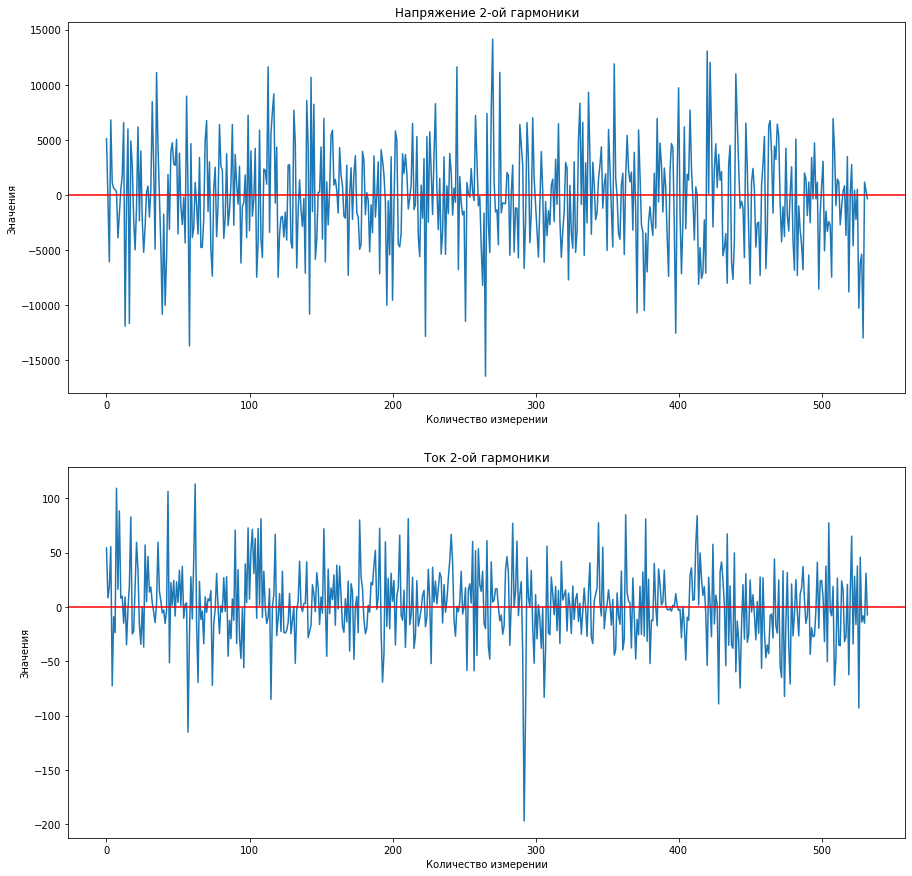

In [13]:
fig, ax = plot.subplots(2, figsize=(15,15))
ax1, ax2 = ax[0], ax[1]

color = "black"

ax1.plot(harU2)


ax1.set_xlabel('Количество измерении').set_color(color)
ax1.set_ylabel('Значения').set_color(color)
ax1.spines['bottom'].set_color(color)
ax1.spines['top'].set_color(color)
ax1.xaxis.label.set_color(color)
ax1.tick_params(axis='x', colors=color)
ax1.tick_params(axis='y', colors=color)


ax2.plot(harI2)

ax2.set_xlabel('Количество измерении').set_color(color)
ax2.set_ylabel('Значения').set_color(color)
ax2.spines['bottom'].set_color(color)
ax2.spines['top'].set_color(color)
ax2.xaxis.label.set_color(color)
ax2.tick_params(axis='x', colors=color)
ax2.tick_params(axis='y', colors=color)

ax1.set_title('Напряжение 2-ой гармоники').set_color(color)
ax2.set_title('Ток 2-ой гармоники').set_color(color)

ax1.axhline(y=0, color='r')
ax2.axhline(y=0, color='r')


plot.show()

In [14]:
#                          !!! ВОТ И САМИ РАСЧЕТЫ !!!
class CalculateLosses():
   
    def __init__(self, podstan, prisoed=None, harm=None, t_izmer=None, distance=None, step=None):
        
        # Проверка на правильность введенных данных для расчета
        assert type(podstan) == PodStans, "Podstan must be PodStand object"
        assert type(prisoed) == int and prisoed != 0 and prisoed <= len(podstan.vse_prisoed), f"Prisoed number must be integer and not equal to zero. And within the range 1 and {len(podstan.vse_prisoed)}"
        if type(harm) == str:
            assert harm.upper() == "ALL", "Type 'ALL' to calculate all harmonics"
            self.all_harms = True
        else:
            assert type(harm) == int and harm < 50 and harm > 1, "Harmonic number must be integer and betweet values 2 and 49"
            self.all_harms = False
        assert type(distance) == int and distance != 0, "Distance number must be integer and not equal to zero"
        assert type(step) in [int, float] and step != 0, "Step size must be integer or float and not equal to zero"

        # Работа с определенным присоединением
        prisoed = getattr(podstan, "prisoed_"+str(prisoed))

        # Проверка налчичя данного измерения по времени в файле EXCEL
        num_record = len(prisoed.faza_B("U").index)
        assert t_izmer-1 <= num_record and t_izmer-1 >= 0, f"Time ticks must be within the range 1 and {num_record+1}"

        self.podstan = podstan
        self.prisoed = prisoed
        self.harm = harm
        self.t_izmer = t_izmer
        self.distance = distance
        self.step = step
        self.tros = 0
        
        self.Us_list = []
        self.Is_list = []
        
        self.prepare_coefficients()
        
    def prepare_coefficients(self):
    
        # Составление матрицы волнового сопротивления Za = в корне(Z/Y)
        Za = sqrtm(np.dot(Z[self.harm-1], inv(Y[self.harm-1])))


        # Составление векторов-столбцов тока и напряжения для начала линии второй гармоники 
        if self.all_harms:
            print("Temporaily Empty case!")
        else:
            volt_phaseA_har = self.prisoed.faza_A.get_harmonic(self.harm, 'U')[self.t_izmer]
            volt_phaseB_har = self.prisoed.faza_B.get_harmonic(self.harm, 'U')[self.t_izmer]
            volt_phaseC_har = self.prisoed.faza_C.get_harmonic(self.harm, 'U')[self.t_izmer]

            curr_phaseA_har = self.prisoed.faza_A.get_harmonic(self.harm, 'I')[self.t_izmer]
            curr_phaseB_har = self.prisoed.faza_B.get_harmonic(self.harm, 'I')[self.t_izmer]
            curr_phaseC_har = self.prisoed.faza_C.get_harmonic(self.harm, 'I')[self.t_izmer]

            U_1 = np.array([[volt_phaseA_har], [volt_phaseB_har], [volt_phaseC_har], [self.tros]])
            I_1 = np.array([[curr_phaseA_har], [curr_phaseB_har], [curr_phaseC_har], [self.tros]])

        # Нахождение векторов-столбцов постоянных интергирования
        self.A1 = np.divide((U_1 + np.dot(Za, I_1)),2)
        self.A2 = np.divide((U_1 - np.dot(Za, I_1)),2)

        self.A3 = np.dot(inv(np.dot(2, Za)), (U_1 + np.dot(Za, I_1)))
        self.A4 = -1*np.dot(inv(np.dot(2, Za)), (U_1 - np.dot(Za, I_1)))


    def calculate_bystep_along_theline(self):
        for shag in Looper(0+self.step, self.distance, self.step):
            pos_U_exponent, neg_U_exponent = calc_exponents(lambda_U, shag)
            pos_I_exponent, neg_I_exponent = calc_exponents(lambda_I, shag)

            Ux = np.dot(neg_U_exponent[self.harm-1], self.A1) + np.dot(pos_U_exponent[self.harm-1], self.A2)
            Ix = np.dot(neg_I_exponent[self.harm-1], self.A3) + np.dot(pos_I_exponent[self.harm-1], self.A4)

            self.Us_list.append(Ux)
            self.Is_list.append(Ix)
        return self.Us_list, self.Is_list


### Как были найдены постоянные интегрирования *(векторы-столбцы)* А(w), B(w), C(w), D(w) ?

<br>
<br>

Как токи и напряжения **в начале** линии были взяты значения тока и напряжения вдоль оси времени. То есть, ток & напряжение в начале линии соответствуют значению тока & напряжения в моменте 2,5 мин *(в начале измерения)*. Данная особенность говорит о том, что постоянные интегрирования (*А, B, C и D*) приобретают **разные значения для каждого момента времени**! Наглядная иллюстрация приведена ниже.
<br>
<br>

![Concept](../materials/sample2.png)
<br>
<br>

Далее, на основе нижеуказанных формул были выведены искомые значения постоянных интегрирования
<br>
<br>

![Formula](../materials/how1.png)
<br>
<br>

Также стоит отметить что значения **тока & напряжения** тоже являются векторами-столбцами с размерностью [4 x 1], как показано на картинке ниже.
Данная особенность гарантирует получение вектора столбца [4 x 1] для постоянных интегрирования **А, В, С и D** и учитывает значения всех трех фазных проводов и троса(-ов).
![Vector](../materials/vector.png)
<br>

**ОСТОРОЖНО! Мои предположения**. Значение троса для тока и напряжения были приняты как 0 (ноль), так как данные для данного провода отсутствуют в файле Excel. Вдобавок, было предположено что влияние магнитного поля троса слабее магнитных полей фазных тросов, в силу разности физических характеристик данных проводов.




In [15]:
if __name__ == "__main__":
    start = time.time()
    calcs = CalculateLosses(PodS_zelenaya, prisoed=1, harm=13, t_izmer=1, distance=1000, step=1)
    Us, Is = calcs.calculate_bystep_along_theline()
    end = time.time()
    print(end - start)

356.19188594818115


Text(0, 0.5, 'Мнимые значения')

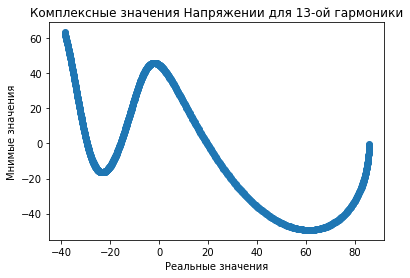

In [16]:
a=[x[0][0] for x in Is]
x = [number.real for number in a]
y = [number.imag for number in a]
plot.scatter(x,y)
plot.title("Комплексные значения Напряжении для 13-ой гармоники")
plot.xlabel("Реальные значения")
plot.ylabel("Мнимые значения")

Text(0, 0.5, 'Абсолютные значения')

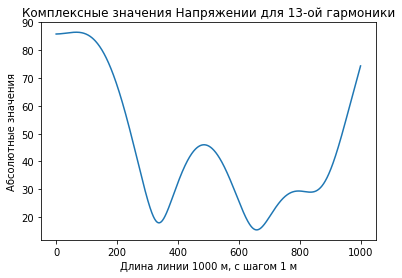

In [17]:
phaseA = [abs(phases[0][0]) for phases in Is]
plot.plot(phaseA)
plot.title("Комплексные значения Напряжении для 13-ой гармоники")
plot.xlabel("Длина линии 1000 м, с шагом 1 м")
plot.ylabel("Абсолютные значения")